In [1]:
import os
import sys
from collections import Counter, defaultdict
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import adaptive_confound.control as acc
import adaptive_confound.utils as acu
import adaptive_confound.topic_model as actm
import adaptive_confound.confound_detection as accd

Using TensorFlow backend.
/home/virgile/.conda/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
import glob
import random
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.sparse as sp
import tensorflow as tf
import keras.backend as K
import json

from copy import deepcopy
from scipy.stats import pearsonr, mode, gmean, hmean, probplot
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics, preprocessing
from tqdm import tqdm
from datetime import datetime
%load_ext autoreload
%autoreload 2

In [3]:
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.15
sess = tf.Session(config=config)
set_session(sess)

In [4]:
import plotly.offline as ply
import plotly.graph_objs as go
ply.init_notebook_mode()

# Data

## Load datasets

In [1832]:
datapath = "/data/virgile/confound/adaptive/in/"
tw_ylzg = acu.read_pickle(os.path.join(datapath, "twitter_dataset_y=location_z=gender.pkl"))
tw_ygzl = acu.read_pickle(os.path.join(datapath, "twitter_dataset_y=gender_z=location.pkl"))
# imdb = acu.read_pickle(os.path.join(datapath, "balanced_imdb.pkl"))
yelp = acu.read_pickle(os.path.join(datapath, "balanced_yelp.pkl"))

datasets = [tw_ylzg, tw_ygzl, yelp]#, imdb]
names = ["Tw y=Loc z=Gender", "Tw y=Gender z=Loc", "Yelp"]#, "IMDb"]
for d, n in zip(datasets, names):
    d.name = n
    print(d)

/home/virgile/.conda/envs/py36/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning:

Trying to unpickle estimator CountVectorizer from version 0.19.0 when using version 0.19.2. This might lead to breaking code or invalid results. Use at your own risk.

/home/virgile/.conda/envs/py36/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning:

Trying to unpickle estimator LabelEncoder from version 0.19.0 when using version 0.19.2. This might lead to breaking code or invalid results. Use at your own risk.



< Dataset: size=6000, p(y)=0.50, p(z)=0.50, bias=0.50, parent=None >
< Dataset: size=6000, p(y)=0.50, p(z)=0.50, bias=0.50, parent=None >
< Dataset: size=14128, p(y)=0.50, p(z)=0.50, bias=0.50, parent=None >


In [1833]:
def make_feature_selection(d, perc):
    d_fts_count = d.X.sum(axis=0).A1
    d_fts_thresh = np.percentile(d_fts_count, perc)
    d_fts_keep = d_fts_count >= d_fts_thresh
    d.X = d.X[:,d_fts_keep]
    d.features = d.features[d_fts_keep]

In [1834]:
for d in datasets:
    print(d.X.shape[1])
    make_feature_selection(d, 60)
    print(d.X.shape[1])

21981
8800
21981
8800
18611
7497


In [1835]:
yelp.X.data = np.array(yelp.X.data > 0).astype(int)
yelp.X

<14128x7497 sparse matrix of type '<class 'numpy.int64'>'
	with 598933 stored elements in Compressed Sparse Row format>

## Create biased datasets

In [2487]:
biases = [.1, .9]
for d in datasets:
    s = 1500
    d.create_biased_datasets(s, biases, k=1)



Generate biased train datasets:   0%|          | 0/2 [00:00<?, ?it/s]

Generate biased train datasets: 100%|██████████| 2/2 [00:00<00:00, 11.92it/s]

                                                                             

Generate biased test datasets:   0%|          | 0/2 [00:00<?, ?it/s]

Generate biased test datasets: 100%|██████████| 2/2 [00:00<00:00, 14.61it/s]

                                                                            

Generate biased train datasets:   0%|          | 0/2 [00:00<?, ?it/s]

Generate biased train datasets: 100%|██████████| 2/2 [00:00<00:00, 14.69it/s]

                                                                             

Generate biased test datasets:   0%|          | 0/2 [00:00<?, ?it/s]

Generate biased test datasets: 100%|██████████| 2/2 [00:00<00:00, 14.82it/s]

                                                                            

Generate biased train datasets:   0%|          | 0/2 [00:00<?, ?it/s]

                 

# Models

## Helpers

In [2457]:
from keras.utils import to_categorical
from IPython.display import HTML, display, display_html

def write_entry(e, path):
    with open(path, "a") as fd:
        e["datetime"] = datetime.now().isoformat()
        print(json.dumps(e), file=fd)

def get_pos_neg_topics(avg_scores, topic_order, n_control):
    avg_scores_sorted = avg_scores[topic_order]
    pos_topics = set(avg_scores_sorted[avg_scores_sorted[:,1] > 0][:n_control, 0].astype(int))
    neg_topics = set(avg_scores_sorted[avg_scores_sorted[:,1] < 0][:n_control, 0].astype(int))
    return pos_topics, neg_topics

def print_control_topics(pos_topics, neg_topics, features, word_score, k=5):
    print("Controlling for the following topics")
    words = []
    topics = []
    for l in [pos_topics, neg_topics]:
        for t in l:
            topics.append(t)
            words.append(features[np.argsort(word_score[t])[::-1][:k]])
    df = pd.DataFrame(np.array(words).T,
                      columns=["Topic #{}".format(t) for t in topics])
    display(HTML(df.to_html()))
    return df

def get_z_label(pred_topics, pos_topics, neg_topics):
    z = []
    for pred_topic in pred_topics:
        pred_pos = set(pred_topic) & pos_topics
        pred_neg = set(pred_topic) & neg_topics
        if pred_pos and not pred_neg:
            z.append(2)
        elif pred_neg and not pred_pos:
            z.append(0)
        else:
            z.append(1)
    z = to_categorical(z, 3)
    return z


def train_prodlda(d_tr, d_te, epochs, n_topics, hidden_dim, batch_size, verbose=1, callbacks=None, **kwargs):
    # Fit ProdLDA
    prodlda = actm.KerasProdLDA(k=d_tr.X.shape[1], m=n_topics,
                                hidden_dim=hidden_dim, batch_size=batch_size, **kwargs)
    h = prodlda.fit(d_tr, d_te, batch_size=batch_size, epochs=epochs,
                    verbose=verbose, callbacks=callbacks)

    p_ygz = softmax(prodlda.model.get_layer("y_hat").get_weights()[0])
    p_xgz = softmax(prodlda.model.get_layer("X_hat").get_weights()[0])
    p_sgz = softmax(prodlda.model.get_layer("s_hat").get_weights()[0])
    
    return prodlda, p_xgz, p_ygz, p_sgz, h

def transform_prodlda(prodlda, d, batch_size, n_top_topics):
    topic_proba = prodlda.transform(d, batch_size=batch_size)
    topics = topic_proba.argsort(axis=1)[:,:-1-n_top_topics:-1]
    return topic_proba, topics

In [11]:
def get_correls(X, y, verbose=0):
    """
    correlations of X and y
    """
    y = np.array(y)
    X_issp = sp.issparse(X)
    safe_X = X
    if X_issp:
        safe_X = X.toarray()
        
    r = []
    loop = range(safe_X.shape[1])
    if verbose:
        loop = tqdm(loop)
    for i in loop:
        check_empty = np.all(safe_X[:,i] == 0) or np.all(y == 0)
        v = 0 if check_empty else pearsonr(safe_X[:,i], y)[0]
        r.append(v)
    return np.array(r)

In [12]:
def softmax(a):
    expa = np.exp(a)
    s = expa.sum(axis=1).reshape(-1,1)
    return expa / s

def compute_weighted_wordcount_per_topic(X, topic_proba):
    # for each topic, multiply the topic distribution of a document
    # by its features value: yields n_topics x n_features x document
    # tensor. sum over documents to get a weighted count of words
    # over topics.
    r = []
    for ti in range(topic_proba.shape[1]):
        tti = topic_proba[:, ti].reshape(-1, 1)
        tti /= tti.sum()
        Xres = X.multiply(tti)
        Xres = Xres.sum(axis=0) 
        if sp.issparse(X):
            Xres = Xres.A1
        r.append(Xres)
    return np.vstack(r)
        
def build_z(rtr, rte, d_tr, d_te, topic_proba_tr, topic_proba_te, xy_corr, k=None, verbose=0):
    #rtr = compute_weighted_wordcount_per_topic(d_tr.X, topic_proba_tr)
    #rte = compute_weighted_wordcount_per_topic(d_te.X, topic_proba_te)
    
    # build distribution of words over topics
    srtr = softmax(rtr)
    srte = softmax(rte)

    # only keep words highly correlated with z to study
    # (using proxy of words correlated with y when high confounding bias)
    top_xy_words = np.abs(xy_corr).argsort()[::-1]
    if k is not None:
        top_xy_words = top_xy_words[:k]
    
    top_xy_features = d_tr.features[top_xy_words]
    top_xy_xy_corr = xy_corr[top_xy_words]
    srtr = srtr[:,top_xy_words]
    srte = srte[:,top_xy_words]

    # compute average position for each word in the squared difference
    # between distribution at training and distribution at testing
    l = d_tr.X.shape[1] - np.square(srtr - srte).argsort(axis=1).mean(axis=0)
    lasort = l.argsort()[::-1]
    lweights = top_xy_xy_corr[lasort]
    
    pos_idx = np.where(lweights > 0)[0]
    pos_words = top_xy_words[ lasort[pos_idx] ]
    pos_weights = lweights[pos_idx]

    neg_idx = np.where(lweights < 0)[0]
    neg_weights = lweights[neg_idx]
    neg_words = top_xy_words[ lasort[neg_idx] ]

    if verbose:
        print("Top + words: {}".format(" ".join(d_tr.features[pos_words[:20]])))
        print("Top - words: {}".format(" ".join(d_tr.features[neg_words[:20]])))
        
    # compute score for each document in the training dataset
    # pos_score: sum of weights of positive words present in the document
    # neg_score: sum of weights of negative words present in the document
    # score = pos_score + neg_score
    z = []
    for xi in d_tr.X:
        p = list( set(pos_words) & set(xi.indices) )
        n = list( set(neg_words) & set(xi.indices) )
        z.append(np.sum(xy_corr[p]) + np.sum(xy_corr[n]))
    z = np.array(z)
    
    return z

In [13]:
def make_z_categorical(z, percentile):
    v0, v1 = np.percentile(z, percentile), np.percentile(z, 100-percentile)
    new_z = np.ones_like(z)
    new_z[z <= v0] = 0
    new_z[z >= v1] = 2
    return to_categorical(new_z, 3)

def make_z_binary(z):
    m = np.median(z)
    new_z = np.ones_like(z)
    new_z[z <= m] = 0
    return new_z

In [14]:
def get_weights(model, layers, apply_softmax=True):
    #return softmax(prodlda.model.get_layer("{}_hat".format(branch)).get_weights()[0])
    ws, bs = [], []
    for l in layers:
        wi, bi = model.get_layer(l).get_weights()
        ws.append(wi)
        bs.append(bi)
        
    for i, (wi, wj, bj) in enumerate(zip(ws, ws[1:], bs[1:])):
        v = wi if i == 0 else r
        r = np.dot(v, wj) + bj
    r = r if not apply_softmax else softmax(r)
    return r

## Experiments

In [15]:
def run_prodlda_abow_experiments_new(datasets, benchpath, prodlda_epochs, abow_epochs, verb=1,
                                     hx=500, ht=200, hc=200, use_last_epoch_model=False,
                                     use_ensemble_model=True, n=5, p=.1,
                                     yz_weight_ratio=1, inv_factor=1):
    # reset saving file
    with open(benchpath, "w"):
        pass

    for d in tqdm(datasets, desc="Iterate datasets"):
        for d_tr in tqdm(list(d.iterate_biased_datasets("train")), leave=False, desc="Iterate train"):
            # Define models
            lr = LogisticRegression()
            abow_hat = acc.A_BOW(d_tr.X.shape[1], 2, hx=hx, ht=ht, hc=hc, use_last_epoch_model=use_last_epoch_model, checkpoint_dir="/data/virgile/checkpointing/abow_hat",
                                 use_ensemble_model=use_ensemble_model, n=n, p=p, yz_weight_ratio=yz_weight_ratio, inv_factor=inv_factor,
                                 optimizer="sgd", z_loss="categorical_crossentropy", z_activation="softmax")

            tr_corr = d_tr.pearsonr[0]
            xy_corr = get_correls(d_tr.X, d_tr.y, verbose=verb)

            for d_te in tqdm(list(d.iterate_biased_datasets("test")), leave=False, desc="Iterate test"):
                ytrue = d_te.y.tolist()
                te_corr = d_te.pearsonr[0]

                if np.abs(tr_corr - te_corr) < .1:
                    continue
                    
                prodlda, phi = train_prodlda(d_tr, d_te, epochs=prodlda_epochs,
                                             n_topics=200, hidden_dim=200, batch_size=50,
                                             verbose=verb, discrim_scaler=1)

                # Compute the top K topic for each document
                topic_proba_tr, topics_tr = transform_prodlda(prodlda, d_tr, 50, 3)
                topic_proba_te, topics_te = transform_prodlda(prodlda, d_te, 50, 3)
                
                # Build Zs
                z_hat = build_z_new(d_tr, d_te, topic_proba_tr, topic_proba_te, xy_corr)
                
                for percentile in [5, 10, 20, 30, 40, 50]:
                    z_hat_cat = make_z_categorical(z_hat, percentile)
                    z_hat_cat = z_hat_cat[:,[0,2]]

                    # Fit and predict with ABOW z_hat
                    d_tr_hat = acu.Dataset(X=d_tr.X, y=d_tr.y, z=z_hat_cat)
                    abow_hat.fit(d_tr_hat, epochs=abow_epochs, verbose=2)
                    ypred = abow_hat.predict(d_te).tolist()
                    e = dict(tr_corr=tr_corr, te_corr=te_corr, ypred=ypred, ytrue=ytrue, model="ABOW_Z_Hat", dataset=d.name, zpred=z_hat.tolist(), ztrue=d_tr.z.tolist(), percentile=percentile)
                    write_entry(e, benchpath)
    return benchpath

In [16]:
def print_units(unit_idx, features, p_ygz, p_sgz, p_xgz, k=10, wrap=4):
    for i in unit_idx:
        sort_words_idx = p_xgz[i].argsort()
        top_pos_idx = sort_words_idx[::-1][:k]
        top_neg_idx = sort_words_idx[:k]
        pl = np.array_split(top_pos_idx, max(k // wrap, 1))
        nl = np.array_split(top_neg_idx, max(k // wrap, 1))
        print("Unit #{} / y: {} / s: {}".format(i, p_ygz[i], p_sgz[i]))
        print("\t- Top + words")
        for i, p in enumerate(pl):
            print("\t\t{} {}".format("-" if i == 0 else " ", " ".join(features[p])))
        print("\t- Top - words")
        for n in nl:
            print("\t\t{} {}".format("-" if i == 0 else " ", " ".join(features[n])))
        print("-"*100)

In [2340]:
d2 = tw_ygzl
d2 = tw_ylzg
# d2 = yelp

d_tr = d2.biased_datasets[0]
d_te = d2.biased_datasets[-1]
d_tr, d_te

(< Dataset: size=1500, p(y)=0.49, p(z)=0.49, bias=0.10, parent=< Dataset: size=6000, p(y)=0.50, p(z)=0.50, bias=0.50, parent=None > >,
 < Dataset: size=1500, p(y)=0.51, p(z)=0.50, bias=0.90, parent=< Dataset: size=6000, p(y)=0.50, p(z)=0.50, bias=0.50, parent=None > >)

In [2341]:
xy_corr = get_correls(d_tr.X, d_tr.y, verbose=1)
xz_corr = get_correls(d_tr.X, d_tr.z, verbose=1)
xs_corr = get_correls(sp.vstack([d_tr.X, d_te.X]),
                      np.hstack([np.ones_like(d_tr.y), np.zeros_like(d_te.y)]),
                      verbose=1)


100%|██████████| 8800/8800 [00:02<00:00, 3213.83it/s]


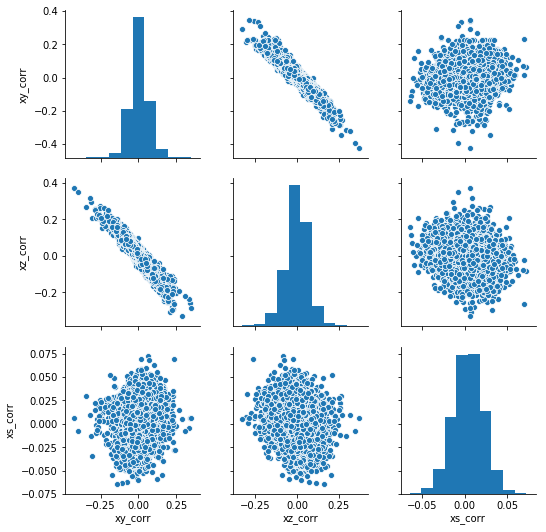

In [2342]:
sns.pairplot(pd.DataFrame(np.array([xy_corr, xz_corr, xs_corr]).T,
                          columns=["xy_corr", "xz_corr", "xs_corr"]))

In [2416]:
from importlib import reload
reload(actm)

<module 'adaptive_confound.topic_model' from '/home/virgile/adaptive_confound/adaptive_confound/topic_model/__init__.py'>

In [2418]:
%%time
from keras.callbacks import *
np.random.seed(1234)
tf.set_random_seed(1234)

weight_path = "/data/virgile/checkpointing/prodlda/.weights_{epoch:03d}.hdf5"
cbs = [
    ModelCheckpoint(monitor="s_loss",
                    filepath=weight_path,
                    save_weights_only=True),
    EarlyStopping(monitor="X_loss", patience=30, min_delta=15)
]

n_topics = 256
hidden_dim = 512
batch_size = 128
epochs = 600

prodlda = actm.KerasProdLDA(k=d_tr.X.shape[1], m=n_topics, batch_size=batch_size,
                            hidden_dim=hidden_dim, alpha=1/n_topics,
                            y_inv_factor=1, s_inv_factor=1, supervised=True,
                            beta0=1, beta1=1, beta2=1, beta3=1)
h = prodlda.fit(d_tr, d_te, batch_size=batch_size, epochs=epochs, verbose=2, callbacks=cbs)

Epoch 1/600
 - 3s - loss: 26874.1688 - X_loss: 16205.0710 - y_loss: 3560.5096 - s_loss: 7001.6522
Epoch 2/600
 - 1s - loss: 27693.1698 - X_loss: 16193.1652 - y_loss: 3906.2748 - s_loss: 7474.7714
Epoch 3/600
 - 1s - loss: 28547.9318 - X_loss: 16189.3969 - y_loss: 4412.3570 - s_loss: 7809.6950
Epoch 4/600
 - 1s - loss: 29105.9608 - X_loss: 16184.0194 - y_loss: 4764.7451 - s_loss: 8017.5833
Epoch 5/600
 - 1s - loss: 29219.6225 - X_loss: 16175.9145 - y_loss: 4703.3977 - s_loss: 8186.1195
Epoch 6/600
 - 1s - loss: 29568.9017 - X_loss: 16171.7745 - y_loss: 5012.8122 - s_loss: 8237.1187
Epoch 7/600
 - 1s - loss: 30324.5218 - X_loss: 16164.2859 - y_loss: 5368.6556 - s_loss: 8631.1653
Epoch 8/600
 - 1s - loss: 30245.7454 - X_loss: 16151.6360 - y_loss: 5499.6673 - s_loss: 8437.2653
Epoch 9/600
 - 1s - loss: 30578.7336 - X_loss: 16147.1239 - y_loss: 5535.1821 - s_loss: 8727.5706
Epoch 10/600
 - 1s - loss: 31024.6638 - X_loss: 16136.4113 - y_loss: 5812.7642 - s_loss: 8901.5951
Epoch 11/600
 - 1s 

In [2422]:
dfh = pd.DataFrame(h.history)
epoch_min = dfh.X_loss.idxmin() + 1
prodlda.model.load_weights(weight_path.format(epoch=epoch_min))
p_ygz = softmax(prodlda.model.get_layer("y_hat").get_weights()[0])
p_xgz = softmax(prodlda.model.get_layer("X_hat").get_weights()[0])
p_sgz = softmax(prodlda.model.get_layer("s_hat").get_weights()[0])
topic_proba_tr, topics_tr = transform_prodlda(prodlda, d_tr, batch_size, 3)
topic_proba_te, topics_te = transform_prodlda(prodlda, d_te, batch_size, 3)

rtr = compute_weighted_wordcount_per_topic(d_tr.X, topic_proba_tr)
rte = compute_weighted_wordcount_per_topic(d_te.X, topic_proba_te)

srtr, srte = softmax(rtr), softmax(rte)
wsrtr, wsrte = softmax(rtr.T), softmax(rte.T)                
wdiff = np.array([accd.hd(_1, _2) for _1,_2 in zip(wsrtr, wsrte)])
control_idx = wdiff.argsort()[::-1]

In [2423]:
wdiff = np.array([accd.hd(_1, _2) for _1,_2 in zip(wsrtr, wsrte)])

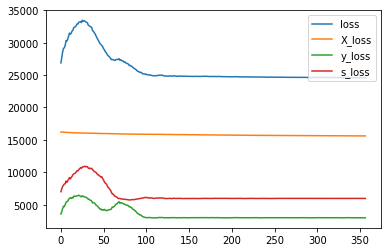

In [2424]:
dfh = pd.DataFrame(h.history)
dfh.plot()

In [2314]:
dfh = pd.DataFrame(h.history)
epoch_min = (dfh.X_loss + dfh.s_loss - dfh.y_loss).idxmin()
# epoch_min = dfh.X_loss.idxmin()
epoch_min = dfh.loss.idxmin()
epoch_min += 1
print(epoch_min)
prodlda.model.load_weights(weight_path.format(epoch=epoch_min))
p_ygz = get_weights(prodlda.model, ["Hy", "y_hat"])
p_sgz = get_weights(prodlda.model, ["Hs", "s_hat"])
p_xgz = get_weights(prodlda.model, ["HX", "X_hat"], apply_softmax=False)
topic_proba_tr, topics_tr = transform_prodlda(prodlda, d_tr, batch_size, 3)
topic_proba_te, topics_te = transform_prodlda(prodlda, d_te, batch_size, 3)

# p_ygz = softmax(prodlda.model.get_layer("y_hat").get_weights()[0])
#p_xgz = softmax(prodlda.model.get_layer("X").get_weights()[0])
# p_sgz = softmax(prodlda.model.get_layer("s_hat").get_weights()[0])


# rtr = compute_weighted_wordcount_per_topic(d_tr.X, topic_proba_tr)
# rte = compute_weighted_wordcount_per_topic(d_te.X, topic_proba_te)

462


/home/virgile/.conda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



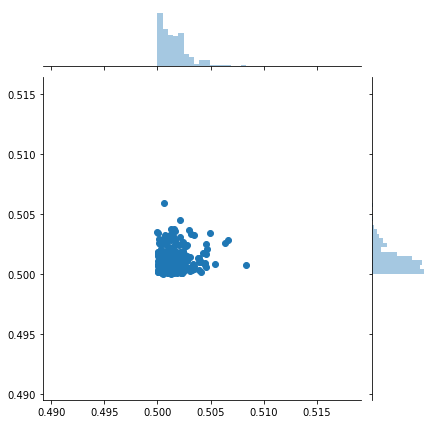

In [2425]:
sns.jointplot(
    p_ygz.max(axis=1),
    p_sgz.max(axis=1)
)

In [2426]:
topic_proba_tr, topics_tr = transform_prodlda(prodlda, d_tr, batch_size, 3)
topic_proba_te, topics_te = transform_prodlda(prodlda, d_te, batch_size, 3)

# rtr = compute_weighted_wordcount_per_topic(d_tr.X, topic_proba_tr)
# rte = compute_weighted_wordcount_per_topic(d_te.X, topic_proba_te)

# srtr, srte = softmax(rtr), softmax(rte)

/home/virgile/.conda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning:

Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.

/home/virgile/.conda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:181: UserWarning:

Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 



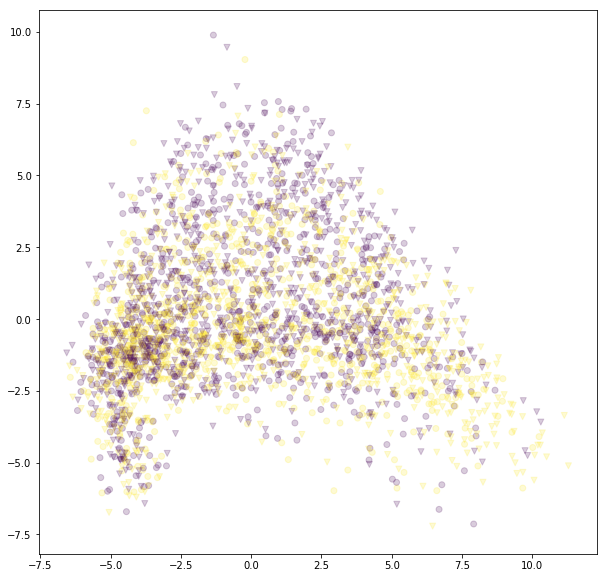

In [2427]:
from sklearn.decomposition import PCA
pca = PCA(2)
t = preprocessing.scale(np.vstack([topic_proba_tr,
                                   topic_proba_te]))
pca.fit(t)
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(*zip(*pca.transform(t[:1500])), c=d_tr.z, marker="o", alpha=.2)
ax.scatter(*zip(*pca.transform(t[1500:])), c=d_te.z, marker="v", alpha=.2)

In [2428]:
k_top_topics = 6
units_score = p_sgz.max(axis=1) - p_ygz.max(axis=1)
predictive_units = units_score.argsort()[::-1][:k_top_topics]
predictive_units = np.abs(get_correls(topic_proba_tr, d_tr.y)).argsort()[::-1][:k_top_topics]
print_units(predictive_units, d_tr.features, p_ygz, p_sgz, p_xgz, k=32, wrap=8)

Unit #109 / y: [0.499586  0.5004141] / s: [0.49720877 0.5027913 ]
	- Top + words
		- kale latte baking coconut latergram avocado carrot veggies
		  salmon smoothie patio garlic diy recipes lemon roadtrip
		  glitter bakery gloomy yummy spinach cocktail pumpkin homemade
		  corn mint greens bean almond cocktails spice veggie
	- Top - words
		  weloverobdyrdek cavs sportscenter woridstarhlphop mayweather lebron meninisttweet worldstarfunny
		  mvp postseason sexualgif refs craziestsex kobebryant wr bruh
		  teammates niggas funnypicsdepot kingjames stevestfler dunk innings madden
		  playoffs rb thefunnyvine preseason nbafinals jeter derrick causewereguys
----------------------------------------------------------------------------------------------------
Unit #145 / y: [0.5002734 0.4997266] / s: [0.5017609 0.4982392]
	- Top + words
		- defensive wr redskins broncos cardinals colts rb ncaa
		  yards coaching drafted scoring athlete cowboys refs qb
		  coaches opponent nhl bleacherreport p

In [2429]:
get_correls(topic_proba_tr, d_tr.y)[predictive_units]

array([-0.17546781,  0.16593029, -0.15190799, -0.14235372,  0.14229086,
       -0.140815  ])

In [2433]:
rbf = lambda x, k: np.exp(- np.square( 2 * x / k ))
# wdiff = np.array([accd.hd(_1, _2) for _1,_2 in zip(wsrtr, wsrte)])
# units_score = 2 * (p_sgz.max(axis=1) - p_ygz.max(axis=1))
# unit_sign = p_sgz.argmax(axis=1)
# unit_sign[unit_sign == 0] = -1
# keep = units_score > 0
# units_score *= unit_sign
# p_xgz_scaled = preprocessing.scale(p_xgz, axis=1)
# units_score_exp = rbf(1-units_score, .8)

# wdiff = np.mean( np.square(p_xgz_scaled[keep]) * units_score[keep].reshape(-1,1), axis=0)

# wdiff = np.mean( np.square( p_xgz[predictive_units] ), axis=0)
# wdiff = np.mean( p_xgz[predictive_units], axis=0 )
# wdiff = np.square(rtr - rte).sum(axis=0)
# wdiff = np.mean(wsrtr - wsrte, axis=1)
wdiff = np.array([accd.hd(_1, _2) for _1,_2 in zip(wsrtr, wsrte)])

control_idx = np.abs(wdiff).argsort()[::-1]
# control_idx = np.square(wdiff).argsort()[::-1]

In [2434]:
sign = np.sign(wdiff)
sign = np.sign(xy_corr)
pos_contidx = control_idx[(sign[control_idx] > 0)]
neg_contidx = control_idx[(sign[control_idx] < 0)]

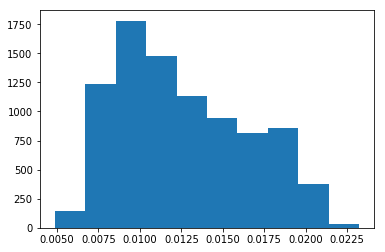

In [2435]:
plt.hist(wdiff);

In [2436]:
d_tr.features[pos_contidx][:100]

array(['york', 'faster', 'pizza', 'cutest', 'fit', 'drinking', 'woman',
       'cause', 'gift', 'loving', 'die', 'okay', 'turning', 'joe', 'bday',
       'lady', 'snow', 'floor', 'lovely', 'running', 'wine', 'eating',
       'cute', 'seat', 'tour', 'knows', 'ugh', 'nyc', 'lt', 'tweets',
       'desk', 'fantastic', 'change', 'st', 'voice', 'wonderful', 'de',
       'island', 'group', 'stars', 'clean', 'starbucks', 'asked', 'http',
       'kids', 'window', 'book', 'filled', 'living', 'excited', 'touch',
       'different', 'loved', 'spent', 'hanging', 'ny', 'whole', 'save',
       'ring', 'yay', 'gym', 'person', 'sometimes', 'sister', 'jersey',
       'memories', 'eyes', 'baby', 'story', 'definitely', 'lives',
       'children', 'idk', 'smile', 'mad', 'sick', 'focus', 'open',
       'choice', 'boys', 'forever', 'minute', 'class', 'sleep', 'energy',
       'fine', '80', 'become', 'til', 'face', 'between', 'international',
       'promise', 'holiday', 'experience', 'afternoon', 'train',
  

In [2437]:
d_tr.features[neg_contidx][:100]

array(['california', 'valley', 'ball', 'ca', 'san', 'angeles', 'beer',
       'los', 'shark', 'father', 'saying', 'wanna', 'physical', 'santa',
       'beach', '90', '12', 'jack', 'market', 'finish', 'fan', 'james',
       'special', 'forward', 'pull', 'la', 'facebook', 'legend',
       'happens', 'started', 'ya', 'sandwich', 'dude', 'media', 'code',
       'online', 'happen', 'hurt', 'yeah', 'htt', 'star', 'success',
       'funny', 'also', 'shift', '99', '30', 'somebody', 'david', 'bring',
       'hollywood', 'king', 'talking', 'cut', '13', 'maybe', 'deal',
       'test', 'vegas', 'fix', 'chance', 'worth', 'wanted', 'pick', 'ok',
       'machine', 'zone', 'final', 'hours', 'goes', 'science', 'yo',
       'team', 'which', '14', 'top', 'lead', 'burger', 'youtube',
       'working', 'podcast', 'event', 'gonna', 'album', 'past', 'inside',
       'ride', 'winning', 'downtown', 'pre', 'term', 'son', 'internet',
       '50', 'haha', 'mark', 'welcome', '2015', 'retweet', 'round'],
      dtyp

In [2438]:
lpos = len(pos_contidx)
lneg = len(neg_contidx)
w_pos = np.abs(wdiff[pos_contidx])
w_neg = np.abs(wdiff[neg_contidx])
k = 3500
w_pos *= rbf(np.arange(lpos), k)
w_neg *= rbf(np.arange(lneg), k)
# w_pos = 1-rbf(w_pos, k)
# w_neg = 1-rbf(w_neg, k)

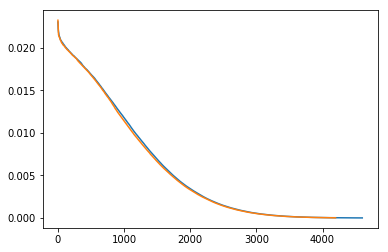

In [2439]:
plt.plot(w_pos)
plt.plot(w_neg)

In [2440]:
pos_w = (d_tr.X[:,pos_contidx].toarray() * w_pos).sum(axis=1)
neg_w = (d_tr.X[:,neg_contidx].toarray() * w_neg).sum(axis=1)
z_hat = np.array(pos_w - neg_w)
new_z = np.ones_like(z_hat)
new_z[z_hat < 0] = 0

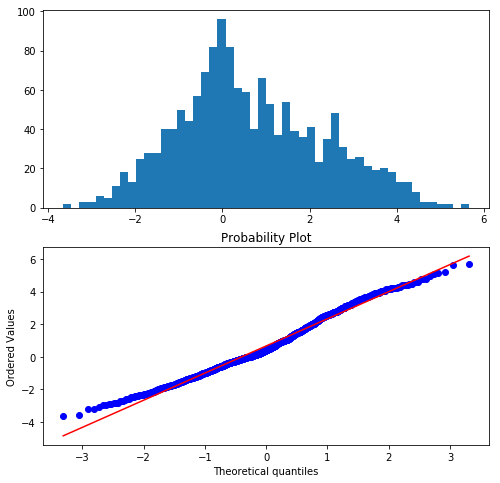

In [2441]:
from scipy.stats import probplot
fig, ax = plt.subplots(2, figsize=(8,8))
ax[0].hist(z_hat, bins=50);
probplot(z_hat, plot=ax[1]);

0 0 495 0.03636363636363636
0 1 267 0.7153558052434457
1 0 84 0.6309523809523809
1 1 654 0.06574923547400612


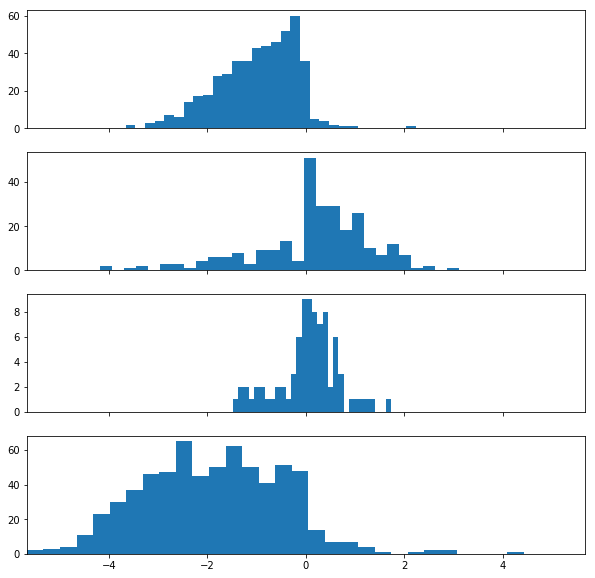

In [2442]:
fig, ax = plt.subplots(4, sharex=True, figsize=(10,10))
m = max(np.abs(z_hat))
for i, (yi, zi) in enumerate([(0,0), (0,1), (1,0), (1,1)]):
    f = (d_tr.y == yi) & (new_z == zi) #& keep
    print(yi, zi, np.sum(f), metrics.accuracy_score(d_tr.z[f], new_z[f]))
    t = np.array([-1 if pi != ti else 1 for ti, pi in zip(d_tr.z[f], new_z[f])])
    ax[i].hist(t*np.abs(z_hat[f]), bins=30)
    ax[i].set_xlim([-1*m,m])

/home/virgile/.conda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no predicted samples.



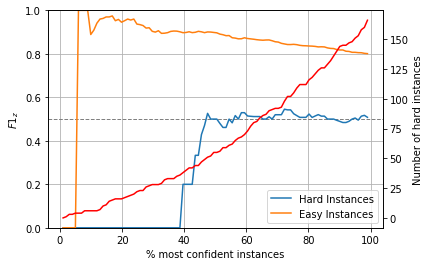

In [2443]:
def plot_f1_z_given_percentile(z_hat, d):
    xplot = []
    yplot = []
    yplot2 = []
    yplot3 = []
    new_z = np.ones_like(z_hat)
    new_z[z_hat < 0] = 0
    
    for most_conf_perc in np.linspace(1, 99, 100):
        z_conf = np.abs(z_hat)
        lim = np.percentile(z_conf, 100-most_conf_perc)
        z_filter = z_conf < lim
        z_conf[z_filter] = 0
        z_conf_0 = np.where(z_conf != 0)[0]
        hard_z_conf_0 = np.where(d.z[z_conf_0] == d.y[z_conf_0])[0] # hard case
        easy_z_conf_0 = np.where(d.z[z_conf_0] != d.y[z_conf_0])[0] # easy case
        xplot.append(most_conf_perc)
        yplot.append(metrics.f1_score(d.z[z_conf_0][hard_z_conf_0], 1-new_z[z_conf_0][hard_z_conf_0]))
        yplot2.append(metrics.f1_score(d.z[z_conf_0][easy_z_conf_0], 1-new_z[z_conf_0][easy_z_conf_0]))
        yplot3.append(len(hard_z_conf_0))
        
    fig, ax = plt.subplots()
    ax.axhline(y=.5, ls="--", c="gray", lw=1)
    ax.plot(xplot, yplot, label="Hard Instances")
    ax.plot(xplot, yplot2, label="Easy Instances")
    ax.grid(True)
    ax.set_ylabel("$F1_z$")
    ax.set_xlabel("% most confident instances")
    ax2 = ax.twinx()
    ax2.plot(xplot, yplot3, 'r')
    ax2.set_ylabel("Number of hard instances")
    ax.legend()
    ax.set_ylim([0,1])
plot_f1_z_given_percentile(z_hat, d_tr)


In [2444]:
y_conf = np.ones(d_tr.y.size)
z_conf = np.abs(z_hat)
most_conf_perc = 100
lim = np.percentile(z_conf, 100-most_conf_perc)
z_filter = z_conf < lim
z_conf[z_filter] = 0
z_conf = preprocessing.minmax_scale(z_conf)

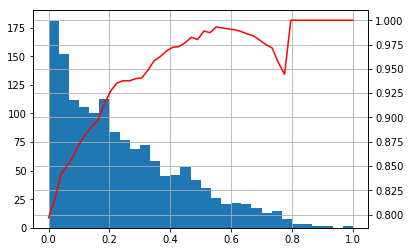

In [2445]:
f1s = []
xplot = []
for i, zc in enumerate(np.linspace(z_conf.min(), z_conf.max(), 50)):
    xplot.append(zc)
    zc_idx = np.where(z_conf >= zc)[0]
    f1 = metrics.accuracy_score(d_tr.z[zc_idx], 1-new_z[zc_idx])
    f1s.append(f1)

fig, ax = plt.subplots()
ax.hist(z_conf, bins=30)
ax2 = ax.twinx()
ax2.plot(xplot, f1s, 'r', label="Z Accuracy")
ax2.grid(True)
ax.xaxis.grid(True)

In [2446]:
t = np.where(z_conf != 0)[0]
t2 = np.where(d_tr.z[t] == d_tr.y[t])[0] # hard case
t3 = np.where(d_tr.z[t] != d_tr.y[t])[0] # easy case

In [2447]:
len(t2)

166

In [2448]:
metrics.f1_score(d_tr.z[t][t2], 1-new_z[t][t2]), metrics.f1_score(d_tr.z[t][t3], 1-new_z[t][t3])

(0.5081967213114754, 0.7989949748743719)

In [2449]:
pearsonr(d_tr.z[t][t2], 1-new_z[t][t2])[0], pearsonr(d_tr.z[t][t3], 1-new_z[t][t3])[0]

(0.2514948338835057, 0.6507271684256636)

In [2337]:
new_dtr = acu.Dataset(
    X = d_tr.X,#[keep],
    y = d_tr.y,#[keep],
    z = new_z
)

d_both = acu.Dataset(
    X = sp.vstack([d_tr.X, d_te.X]),
    y = np.hstack([d_tr.y, np.zeros_like(d_te.y)]),
    z = np.hstack([new_z,  np.zeros_like(d_te.z)]),
#     z = np.vstack([new_z,  np.zeros_like(new_z)]),
    domain = np.hstack([np.zeros_like(d_tr.y), np.ones_like(d_te.y)])
)

In [2460]:
abow_hat = acc.A_BOW(d_tr.X.shape[1], 1, h1=100, h2=50, checkpoint_dir="/data/virgile/checkpointing/abow_hat",
                     dropout_rate=.25, loss_weights={"y":1, "z":1},
                     z_inv_factor=1, optimizer="sgd"
                    )

# abow_hat = acc.A_BOW(d_tr.X.shape[1], new_z.shape[1], h1=500, h2=200,
#                      checkpoint_dir="/data/virgile/checkpointing/abow_hat",
#                      dropout_rate=.5, loss_weights={"y":1, "z":1.5}, z_inv_factor=1,
#                      z_loss="categorical_crossentropy", z_activation="softmax"#, optimizer="sgd"
#                     )

dnn = acc.A_BOW(d_tr.X.shape[1], 1, h1=100, h2=50, checkpoint_dir="/data/virgile/checkpointing/dnn",
                dropout_rate=.25, loss_weights={"y":1, "z":0})

In [2471]:
tw_ylzg.create_biased_datasets(1500, [.5], k=2)


Generate biased train datasets: 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]
                                                                             
Generate biased test datasets: 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]
                                                                            

In [2476]:
f1s = []
for d_tr in tw_ylzg.iterate_biased_datasets("train"):
    for d_te in tw_ylzg.iterate_biased_datasets("test"):
        dnn.fit(d_tr, epochs=600, batch_size=batch_size, verbose=2)
        f1s.append(metrics.f1_score(d_te.y, dnn.predict(d_te)))

Epoch 1/600
 - 1s - loss: 3.9488 - y_loss: 0.6918 - z_loss: 0.7719 - y_acc: 0.5440 - z_acc: 0.5013
Epoch 2/600
 - 0s - loss: 3.7986 - y_loss: 0.6410 - z_loss: 0.8243 - y_acc: 0.6487 - z_acc: 0.5100
Epoch 3/600
 - 0s - loss: 3.6454 - y_loss: 0.5899 - z_loss: 0.8613 - y_acc: 0.7220 - z_acc: 0.5060
Epoch 4/600
 - 0s - loss: 3.4917 - y_loss: 0.5375 - z_loss: 0.9024 - y_acc: 0.7733 - z_acc: 0.5007
Epoch 5/600
 - 0s - loss: 3.3473 - y_loss: 0.4925 - z_loss: 0.9202 - y_acc: 0.8027 - z_acc: 0.5107
Epoch 6/600
 - 0s - loss: 3.2031 - y_loss: 0.4447 - z_loss: 0.9844 - y_acc: 0.8580 - z_acc: 0.5067
Epoch 7/600
 - 0s - loss: 3.0678 - y_loss: 0.4025 - z_loss: 0.9532 - y_acc: 0.8780 - z_acc: 0.5087
Epoch 8/600
 - 0s - loss: 2.9305 - y_loss: 0.3548 - z_loss: 0.9968 - y_acc: 0.9080 - z_acc: 0.5033
Epoch 9/600
 - 0s - loss: 2.8177 - y_loss: 0.3280 - z_loss: 1.0163 - y_acc: 0.9173 - z_acc: 0.5113
Epoch 10/600
 - 0s - loss: 2.7037 - y_loss: 0.2964 - z_loss: 0.9899 - y_acc: 0.9260 - z_acc: 0.5020
Epoch 11/

In [2478]:
np.mean(f1s)

0.876898579488822

In [2339]:
sample_weight = {"y": y_conf, "z": z_conf}
val_z = d_te.z

# sample_weight = {"y": y_conf, "z": y_conf}
# val_z = np.zeros_like(new_z)
abow_hat.fit(new_dtr, epochs=600, verbose=2,
             validation_data=(d_te.X, [d_te.y, val_z]),
             batch_size=batch_size, sample_weight=sample_weight)

Train on 1500 samples, validate on 1500 samples
Epoch 1/600
 - 1s - loss: 4.7174 - y_loss: 0.7031 - z_loss: 0.7215 - y_acc: 0.5307 - z_acc: 0.2253 - val_loss: 6.2899 - val_y_loss: 0.6667 - val_z_loss: 2.3391 - val_y_acc: 0.5887 - val_z_acc: 0.5147
Epoch 2/600
 - 0s - loss: 4.9226 - y_loss: 0.7201 - z_loss: 0.9254 - y_acc: 0.5567 - z_acc: 0.2260 - val_loss: 4.5972 - val_y_loss: 0.6392 - val_z_loss: 0.6898 - val_y_acc: 0.6347 - val_z_acc: 0.5360
Epoch 3/600
 - 0s - loss: 3.9986 - y_loss: 0.6377 - z_loss: 0.0997 - y_acc: 0.6460 - z_acc: 0.7747 - val_loss: 4.8381 - val_y_loss: 0.6084 - val_z_loss: 0.9772 - val_y_acc: 0.7000 - val_z_acc: 0.4927
Epoch 4/600
 - 0s - loss: 3.9245 - y_loss: 0.6070 - z_loss: 0.0720 - y_acc: 0.6893 - z_acc: 0.7980 - val_loss: 4.8970 - val_y_loss: 0.5897 - val_z_loss: 1.0703 - val_y_acc: 0.7213 - val_z_acc: 0.4927
Epoch 5/600
 - 0s - loss: 3.8711 - y_loss: 0.5712 - z_loss: 0.0697 - y_acc: 0.7120 - z_acc: 0.7987 - val_loss: 4.9069 - val_y_loss: 0.5801 - val_z_loss:

KeyboardInterrupt: 

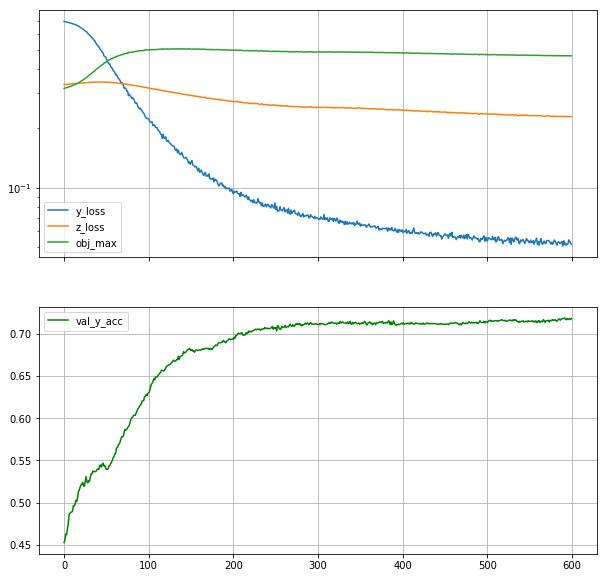

In [798]:
dfhistory = pd.DataFrame(abow_hat.history.history).dropna()
# dfhistory["obj_min"] = dfhistory.y_loss - dfhistory.z_loss
dfhistory["obj_max"] = gmean(np.vstack([1 - dfhistory.y_loss, dfhistory.z_loss]))

fig, ax = plt.subplots(2, sharex=True, figsize=(10,10))
dfhistory[["y_loss", "z_loss", "obj_max"]].plot(logy=True, grid=True, ax=ax[0])
dfhistory[["val_y_acc"]].plot(grid=True, ax=ax[1], style=["g-"]);

In [799]:
dfhistory.val_y_acc.iloc[dfhistory.obj_max.idxmax()+1]

0.6726666669845581

In [801]:
abow_hat.model.load_weights(abow_hat.cpt_name.format(epoch=600))
# abow_hat.load_best_model()
ypred = abow_hat.predict(d_te)
metrics.f1_score(d_te.y, ypred)

0.7159167226326393

In [2229]:
def get_word_importance(model_weights):
    r = None
    for w, b in zip(model_weights[::2], model_weights[1::2]):
        if r is None:
            r = w + b
        else:
            r = np.dot(r, w) + b
    return r.flatten()

In [2231]:
abow_both = acc.A_BOW(d_both.X.shape[1], 1, h1=100, h2=50, checkpoint_dir="/data/virgile/checkpointing/abow_both",
                      use_domain=True, z_inv_factor=1, d_inv_factor=1, dropout_rate=.25, optimizer="sgd",
                      loss_weights={"y":1, "z":1, "d":1})

sample_weight = {"y": np.hstack([np.ones_like(d_tr.y), np.zeros_like(d_te.y)]),
                 "z": np.hstack([z_conf, np.zeros_like(d_te.y)]),
                 "d": np.ones_like(d_both.y)}
abow_both.fit(d_both, epochs=600, verbose=2,
              validation_data=(d_te.X, [d_te.y, d_te.z, np.zeros_like(d_te.z)]),
              batch_size=batch_size, sample_weight=sample_weight)

Train on 3000 samples, validate on 1500 samples
Epoch 1/600
 - 1s - loss: 5.4386 - y_loss: 0.6906 - z_loss: 0.0807 - d_loss: 0.6960 - y_acc: 0.5090 - z_acc: 0.4260 - d_acc: 0.4933 - val_loss: 5.9864 - val_y_loss: 0.6914 - val_z_loss: 0.6916 - val_d_loss: 0.6525 - val_y_acc: 0.5180 - val_z_acc: 0.5233 - val_d_acc: 0.9287
Epoch 2/600
 - 0s - loss: 5.3973 - y_loss: 0.6867 - z_loss: 0.0809 - d_loss: 0.6963 - y_acc: 0.5653 - z_acc: 0.4327 - d_acc: 0.4910 - val_loss: 5.9515 - val_y_loss: 0.6911 - val_z_loss: 0.6916 - val_d_loss: 0.6554 - val_y_acc: 0.5167 - val_z_acc: 0.5327 - val_d_acc: 0.9013
Epoch 3/600
 - 0s - loss: 5.3556 - y_loss: 0.6826 - z_loss: 0.0809 - d_loss: 0.6962 - y_acc: 0.6080 - z_acc: 0.4557 - d_acc: 0.4827 - val_loss: 5.9163 - val_y_loss: 0.6909 - val_z_loss: 0.6917 - val_d_loss: 0.6577 - val_y_acc: 0.5187 - val_z_acc: 0.5353 - val_d_acc: 0.8787
Epoch 4/600
 - 0s - loss: 5.3150 - y_loss: 0.6770 - z_loss: 0.0815 - d_loss: 0.6978 - y_acc: 0.6440 - z_acc: 0.4727 - d_acc: 0.483

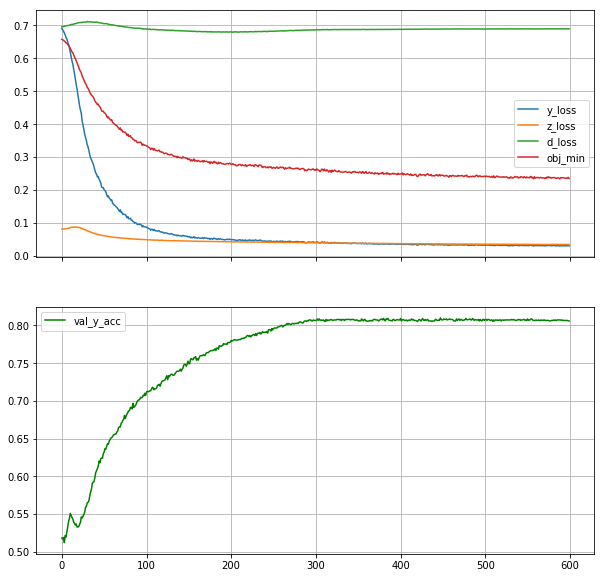

In [2232]:
dfhistory = pd.DataFrame(abow_both.history.history).dropna()
dfhistory["obj_min"] = gmean(np.vstack([dfhistory.y_loss, 1.1 - dfhistory.z_loss, 1.1 - dfhistory.d_loss]))
fig, ax = plt.subplots(2, sharex=True, figsize=(10,10))
dfhistory[["y_loss", "z_loss", "d_loss", "obj_min"]].plot(logy=False, grid=True, ax=ax[0])
dfhistory[["val_y_acc"]].plot(grid=True, ax=ax[1], style=["g-"]);

In [2233]:
abow_both.load_best_model()
# abow_both.model.load_weights(abow_both.cpt_name.format(epoch=503))

ypred = abow_both.predict(d_te)
metrics.f1_score(d_te.y, ypred)

589


0.8087359364659166

In [2234]:
lr = LogisticRegression()
lr.fit(d_tr.X, d_tr.y)
ypred_lr = lr.predict(d_te.X)
metrics.f1_score(d_te.y, ypred_lr)

0.7109634551495017

In [2489]:
def run_prodlda_abow_experiments(datasets, benchpath, prodlda_epochs, abow_epochs, verb=1, batch_size=128,
                                 h1=100, h2=50, dropout_rate=.25, z_inv_factor=1, d_inv_factor=1):
    # reset saving file
    with open(benchpath, "w"):
        pass

    abow_fit_kwargs = dict(epochs=abow_epochs, verbose=verb, batch_size=batch_size)
    common_kwargs = dict(h1=h1, h2=h2, z_inv_factor=z_inv_factor, d_inv_factor=d_inv_factor, 
                         dropout_rate=dropout_rate, optimizer="sgd")
    count = 0
    for d in tqdm(datasets, desc="Datasets"):
        for d_tr in tqdm(list(d.iterate_biased_datasets("train")), leave=False, desc="TR for {}".format(d.name)):
            # Dataset info and common parameters
            k = d_tr.X.shape[1]
            tr_corr = d_tr.pearsonr[0]
            xy_corr = get_correls(d_tr.X, d_tr.y, verbose=verb)

            # Define models
#             lr = LogisticRegression()
#             dnn = acc.A_BOW(k, 1, checkpoint_dir="/data/virgile/checkpointing/dnn",
#                             loss_weights={"y":1, "z":0}, **common_kwargs)
#             abow_true = acc.A_BOW(k, 1, checkpoint_dir="/data/virgile/checkpointing/abow_true", **common_kwargs)
#             abow_hat = acc.A_BOW(k, 1, loss_weights={"y":1, "z":1},
#                                  checkpoint_dir="/data/virgile/checkpointing/abow_hat", **common_kwargs)
#             abow_da = acc.A_BOW(k, 1, checkpoint_dir="/data/virgile/checkpointing/abow_da", **common_kwargs)
#             abow_da_hat = acc.A_BOW(k, 1, use_domain=True, loss_weights={"y":1, "z":1, "d":1},
#                                     checkpoint_dir="/data/virgile/checkpointing/abow_da_hat",
#                                     **common_kwargs)
                             
            # Fit LR
#             lr.fit(d_tr.X, d_tr.y)
            
            for d_te in tqdm(list(d.iterate_biased_datasets("test")), leave=False, desc="TE for {}".format(d.name)):
                # Dataset info
                ytrue = d_te.y.tolist()
                ztrue = d_te.z.tolist()
                te_corr = d_te.pearsonr[0]
                
                if np.abs(tr_corr - te_corr) < .1:
                    continue
                    
                def get_entry(ypred, model, model_name, **kwargs):
                    # get model weights at the word level
                    if model_name != "LR":
                        ws = model.pred_model.get_weights()
                        wi = get_word_importance(ws)
                    else:
                        wi = model.coef_[0]
                    wi = wi.tolist()
            
                    e = dict(tr_corr=tr_corr, te_corr=te_corr, ypred=ypred,
                             ytrue=ytrue, ztrue=ztrue, model=model_name, dataset=d.name,
                             word_importance=wi, features=d_tr.features.tolist())
                    for k, v in kwargs.items():
                        e[k] = v
                    return e
                
                # Predict with LR
#                 e = get_entry( lr.predict(d_te.X).tolist(), lr, "LR" )
#                 write_entry(e, benchpath)

                # Fit and predict with ABOW true
#                 abow_true.fit(d_tr, **abow_fit_kwargs)
#                 e = get_entry( abow_true.predict(d_te).tolist(), abow_true, "ABOW_Z_True", model_selection="Last" )
#                 write_entry(e, benchpath)
                
#                 abow_true.load_best_model()
#                 e = get_entry( abow_true.predict(d_te).tolist(), abow_true, "ABOW_Z_True", model_selection="Best" )
#                 write_entry(e, benchpath)
                
                # Fit and predict with DNN
#                 dnn.fit(d_tr, **abow_fit_kwargs)
#                 e = get_entry( dnn.predict(d_te).tolist(), dnn, "DNN", model_selection="Last" )
#                 write_entry(e, benchpath)
                
#                 dnn.load_best_model()
#                 e = get_entry( dnn.predict(d_te).tolist(), dnn, "DNN", model_selection="Best" )
#                 write_entry(e, benchpath)
                
                # Fit and predict with ABOW domain adaptation
#                 d_da = acu.Dataset(
#                     X=sp.vstack([d_tr.X, d_te.X]),
#                     y=np.hstack([d_tr.y, np.zeros_like(d_te.y)]),
#                     z=np.hstack([np.zeros_like(d_tr.y), np.ones_like(d_te.y)])
#                 )
#                 da_weights = dict(
#                     y=np.hstack([np.ones_like(d_tr.y), np.zeros_like(d_te.y)]),
#                     z=np.hstack([np.ones_like(d_tr.y), np.ones_like(d_te.y)])
#                 )
#                 abow_da.fit(d_da, sample_weight=da_weights, **abow_fit_kwargs)
#                 e = get_entry( abow_da.predict(d_te).tolist(), abow_da, "ABOW_DA", model_selection="Last" )
#                 write_entry(e, benchpath)
                
#                 abow_da.load_best_model()
#                 e = get_entry( abow_da.predict(d_te).tolist(), abow_da, "ABOW_DA", model_selection="Best" )
#                 write_entry(e, benchpath)
                
                # Build Zs
                weight_path = "/data/virgile/checkpointing/prodlda/weights_{epoch:03d}.hdf5"
                cbs = [
                    ModelCheckpoint(monitor="s_loss",
                                    filepath=weight_path,
                                    save_weights_only=True),
#                     EarlyStopping(monitor="X_loss", min_delta=15, patience=30)
                ]

                
                n_topics = 128
                hidden_dim = 256
                prodlda, p_xgz, p_ygz, p_sgz, h = train_prodlda(d_tr, d_te, epochs=prodlda_epochs, n_topics=n_topics,
                                                                callbacks=cbs, alpha=1/n_topics,
                                                                hidden_dim=hidden_dim, batch_size=batch_size, verbose=verb,
                                                                y_inv_factor=1, s_inv_factor=1, supervised=True,
                                                                beta0=1, beta1=1, beta2=1, beta3=1, beta4=0)

                dfh = pd.DataFrame(h.history)
                epoch_min = dfh.X_loss.idxmin() + 1
                prodlda.model.load_weights(weight_path.format(epoch=epoch_min))
                p_ygz = softmax(prodlda.model.get_layer("y_hat").get_weights()[0])
                p_xgz = softmax(prodlda.model.get_layer("X_hat").get_weights()[0])
                p_sgz = softmax(prodlda.model.get_layer("s_hat").get_weights()[0])
                topic_proba_tr, topics_tr = transform_prodlda(prodlda, d_tr, batch_size, 3)
                topic_proba_te, topics_te = transform_prodlda(prodlda, d_te, batch_size, 3)

                rtr = compute_weighted_wordcount_per_topic(d_tr.X, topic_proba_tr)
                rte = compute_weighted_wordcount_per_topic(d_te.X, topic_proba_te)

                srtr, srte = softmax(rtr), softmax(rte)
                wsrtr, wsrte = softmax(rtr.T), softmax(rte.T)                
                wdiff = np.array([accd.hd(_1, _2) for _1,_2 in zip(wsrtr, wsrte)])
                control_idx = wdiff.argsort()[::-1]
                sign = np.sign(xy_corr)
                pos_contidx = control_idx[(sign[control_idx] > 0)]
                neg_contidx = control_idx[(sign[control_idx] < 0)]
                w_pos = wdiff[pos_contidx]
                w_neg = wdiff[neg_contidx]
                
                pos_w = (d_tr.X[:,pos_contidx].toarray() * w_pos).sum(axis=1)
                neg_w = (d_tr.X[:,neg_contidx].toarray() * w_neg).sum(axis=1)
                z_hat = np.array(pos_w - neg_w)
                new_z = np.ones_like(z_hat).astype(int)
                new_z[z_hat < 0] = 0
                
                y_conf = np.ones(d_tr.y.size)
                z_conf = np.abs(z_hat)
                z_conf = preprocessing.minmax_scale(z_conf)

                # training data to control for discovered words
#                 d_tr_hat = acu.Dataset(
#                     X = d_tr.X,
#                     y = d_tr.y,
#                     z = new_z
#                 )

                # Fit and predict with ABOW z_hat
                sample_weight = {"y": y_conf, "z": z_conf}
#                 abow_hat.fit(d_tr_hat,
#                              sample_weight=sample_weight,
#                              **abow_fit_kwargs)
#                 e = get_entry( abow_hat.predict(d_te).tolist(), abow_hat, "ABOW_Z_Hat", model_selection="Last",
#                               z_hat=new_z.tolist(), z_conf=z_conf.tolist() )
#                 write_entry(e, benchpath)

#                 abow_hat.load_best_model()
#                 e = get_entry( abow_hat.predict(d_te).tolist(), abow_hat, "ABOW_Z_Hat", model_selection="Best",
#                                z_hat=new_z.tolist(), z_conf=z_conf.tolist() )
#                 write_entry(e, benchpath)
                
                # data for domain adaptation + z hat
                d_both = acu.Dataset(
                    X = sp.vstack([d_tr.X, d_te.X]),
                    y = np.hstack([d_tr.y, np.zeros_like(d_te.y)]),
                    z = np.hstack([new_z,  np.zeros_like(d_te.z)]),
                    domain = np.hstack([np.zeros_like(d_tr.y),
                                        np.ones_like(d_te.y)])
                )
                sample_weight = dict(
                    y=np.hstack([np.ones_like(d_tr.y), np.zeros_like(d_te.y)]),
                    z=np.hstack([z_conf, np.zeros_like(d_te.y)]),
                    d=np.ones_like(d_both.y)
                )

                for z_weight in [.001, .01, .1, 1, 10, 100]:
                    abow_da_hat = acc.A_BOW(k, 1, use_domain=True, loss_weights={"y":1, "z":z_weight, "d":1},
                            checkpoint_dir="/data/virgile/checkpointing/abow_da_hat",
                            **common_kwargs)

                    # Fit and predict with ABOW z_hat + DA
                    abow_da_hat.fit(d_both, sample_weight=sample_weight, **abow_fit_kwargs)
                    ypred = abow_da_hat.predict(d_te).tolist()
                    e = get_entry( ypred, abow_da_hat, "ABOW_Z_Hat+DA", model_selection="Last",
                                   z_hat=new_z.tolist(), z_conf=z_conf.tolist(), z_loss_val=z_weight )
                    write_entry(e, benchpath)
                    
#                     abow_da_hat.load_best_model()
#                     e = get_entry( abow_da_hat.predict(d_te).tolist(), abow_da_hat, "ABOW_Z_Hat+DA", model_selection="Best",
#                                    z_hat=new_z.tolist(), z_conf=z_conf.tolist() )
#                     write_entry(e, benchpath)
    return benchpath

In [2490]:
run_prodlda_abow_experiments([tw_ylzg], "./abow_benchmark_sgd_sensitivity.jsonl",
                             600, 600, batch_size=128, verb=0)
#                              1, 1, batch_size=128, verb=0)



Datasets:   0%|          | 0/1 [00:00<?, ?it/s]


TR for Tw y=Loc z=Gender:   0%|          | 0/2 [00:00<?, ?it/s]



TE for Tw y=Loc z=Gender:   0%|          | 0/2 [00:00<?, ?it/s]
                                                                        


TE for Tw y=Loc z=Gender: 100%|██████████| 2/2 [26:00<00:00, 780.09s/it]


                                                                        

TR for Tw y=Loc z=Gender:  50%|█████     | 1/2 [26:01<26:01, 1561.17s/it]


TE for Tw y=Loc z=Gender:   0%|          | 0/2 [00:00<?, ?it/s]


TE for Tw y=Loc z=Gender:  50%|█████     | 1/2 [28:06<28:06, 1686.40s/it]


                                                                         

TR for Tw y=Loc z=Gender: 100%|██████████| 2/2 [54:08<00:00, 1599.02s/it]

                                                                         
Datasets: 100%|██████████| 1/1 [54:08<00:00, 3248.49s/it]


'./abow_benchmark_sgd_sensitivity.jsonl'